## 📊 Credit Risk Classification Dataset

### 🧾 Overview
This dataset is designed for binary classification tasks related to credit risk. It helps in predicting whether a customer is **risky (1)** or **not risky (0)** based on demographic and financial data.

### 🗂️ Contents
- **Demographic Features**: Includes variables like age, income, employment status, etc.
- **Financial/Transaction Features**: Covers credit usage, account balance, payment history, and more.
- **Target Variable**:
  - `0` = Not risky (creditworthy)
  - `1` = Risky (likely to default)

### 🎯 Potential Use Cases
- Building credit risk prediction models for financial institutions.
- Experimenting with techniques to handle imbalanced classification.
- Comparing performance of classical models (Logistic Regression) vs. advanced models (Random Forest, XGBoost, Neural Networks).

In [20]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
customer_data = pd.read_csv('customer_data.csv')
payment_data = pd.read_csv('payment_data.csv')

customer_data_head = customer_data.head()
payment_data_head = payment_data.head()

customer_data_head, payment_data_head

(   label        id  fea_1   fea_2  fea_3     fea_4  fea_5  fea_6  fea_7  \
 0      1  54982665      5  1245.5      3   77000.0      2     15      5   
 1      0  59004779      4  1277.0      1  113000.0      2      8     -1   
 2      0  58990862      7  1298.0      1  110000.0      2     11     -1   
 3      1  58995168      7  1335.5      1  151000.0      2     11      5   
 4      0  54987320      7     NaN      2   59000.0      2     11      5   
 
    fea_8  fea_9  fea_10      fea_11  
 0    109      5  151300  244.948974  
 1    100      3  341759  207.173840  
 2    101      5   72001    1.000000  
 3    110      3   60084    1.000000  
 4    108      4  450081  197.403141  ,
          id  OVD_t1  OVD_t2  OVD_t3  OVD_sum  pay_normal  prod_code  \
 0  58987402       0       0       0        0           1         10   
 1  58995151       0       0       0        0           1          5   
 2  58997200       0       0       0        0           2          5   
 3  54988608       

In [22]:
# Datasets merged on 'id' using an inner join to retain only matching ids
merged_df = pd.merge(customer_data, payment_data, on='id', how='inner')

# Display first few rows of the merged dataframe
print(merged_df.head())
print(merged_df.shape)

   label        id  fea_1   fea_2  fea_3     fea_4  fea_5  fea_6  fea_7  \
0      1  54982665      5  1245.5      3   77000.0      2     15      5   
1      1  54982665      5  1245.5      3   77000.0      2     15      5   
2      1  54982665      5  1245.5      3   77000.0      2     15      5   
3      1  54982665      5  1245.5      3   77000.0      2     15      5   
4      0  59004779      4  1277.0      1  113000.0      2      8     -1   

   fea_8  ...  OVD_t2  OVD_t3  OVD_sum  pay_normal  prod_code  prod_limit  \
0    109  ...       0       0        0           9         10     60500.0   
1    109  ...       0       0        0          18         10         NaN   
2    109  ...       0       0        0           1          5         NaN   
3    109  ...       2      26    11906           6         10         NaN   
4    100  ...       0       0        0           4          6         NaN   

   update_date  new_balance  highest_balance  report_date  
0   31/01/2015       6657.

C:\Users\Anders\AppData\Local\Temp\ipykernel_24380\4226571938.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=merged_df, palette='viridis')


Text(0.5, 0, 'Label')

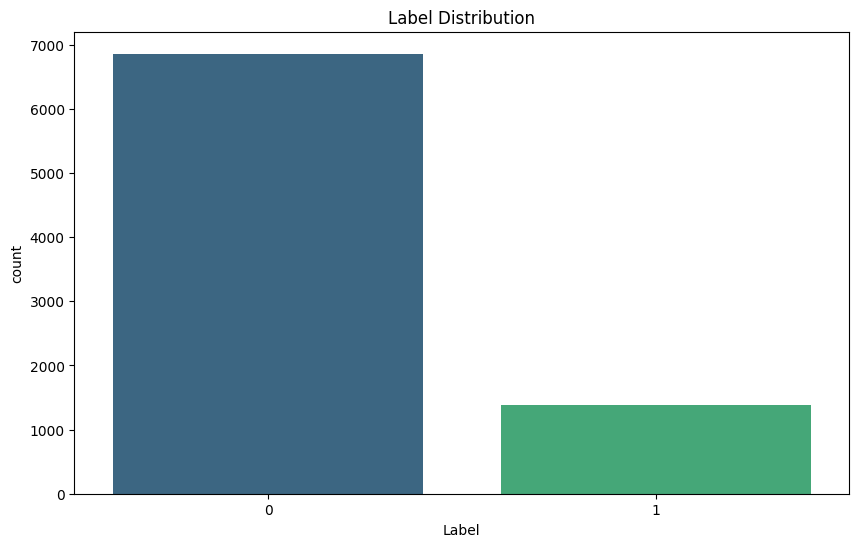

In [23]:
# Vizualize the label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=merged_df, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')


### Using SMOTE for imbalance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Define features and target
X = merged_df.drop(columns=['label', 'id', 'update_date', 'report_date'])  # Exclude non-features
y = merged_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=10
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying SMOTE
smote = SMOTE(random_state=10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Class distribution after SMOTE
resampled_distribution = y_train_smote.value_counts()
resampled_distribution


label
0    4804
1    4804
Name: count, dtype: int64

# Model Testing with Hyperparameter Tuning included

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Hyperparameter distributions
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']  # solvers that support both L1 and L2
}

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=10)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit the model on SMOTE-resampled and scaled training data
random_search.fit(X_train_smote, y_train_smote)

# Best model
best_logreg = random_search.best_estimator_

# Predict on the scaled original test set
y_pred_lr = best_logreg.predict(X_test_scaled)
y_proba_lr = best_logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nLogistic Regression 📊 Classification Report")
print(classification_report(y_test, y_pred_lr, digits=4))
print(f"AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")




Best Parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 100}

Logistic Regression 📊 Classification Report
              precision    recall  f1-score   support

           0     0.8970    0.5877    0.7101      2059
           1     0.2460    0.6659    0.3593       416

    accuracy                         0.6008      2475
   macro avg     0.5715    0.6268    0.5347      2475
weighted avg     0.7875    0.6008    0.6511      2475

AUC: 0.6686


C:\Users\Anders\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter distributions
param_dist = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize model
dtree = DecisionTreeClassifier(random_state=10)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dtree,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit model on SMOTE-resampled and scaled training data
random_search.fit(X_train_smote, y_train_smote)

# Best model
best_dtree = random_search.best_estimator_

# Predict on the scaled original test set
y_pred_dt = best_dtree.predict(X_test_scaled)
y_proba_dt = best_dtree.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nDecision Tree 🌳 Classification Report")
print(classification_report(y_test, y_pred_dt, digits=4))
print(f"AUC: {roc_auc_score(y_test, y_proba_dt):.4f}")



Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 15, 'criterion': 'gini'}

Decision Tree 🌳 Classification Report
              precision    recall  f1-score   support

           0     0.9630    0.9471    0.9549      2059
           1     0.7578    0.8197    0.7875       416

    accuracy                         0.9257      2475
   macro avg     0.8604    0.8834    0.8712      2475
weighted avg     0.9285    0.9257    0.9268      2475

AUC: 0.9300


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Hyperparameter distributions
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize base model
rf = RandomForestClassifier(random_state=10)

# Setting up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fits the model on SMOTE-resampled and scaled training data
random_search.fit(X_train_smote, y_train_smote)

# Best model
best_rf = random_search.best_estimator_

# Predict on the scaled original test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nRandom Forest 🌲 Classification Report")
print(classification_report(y_test, y_pred_rf, digits=4))
print(f"AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

Random Forest 🌲 Classification Report
              precision    recall  f1-score   support

           0     0.9379    0.9835    0.9602      2059
           1     0.8924    0.6779    0.7705       416

    accuracy                         0.9321      2475
   macro avg     0.9152    0.8307    0.8653      2475
weighted avg     0.9303    0.9321    0.9283      2475

AUC: 0.9600


### XGBoost

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Define hyperparameter distributions
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=10)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=10,
    n_jobs=-1
)

# Fit model on SMOTE-resampled and scaled training data
random_search.fit(X_train_smote, y_train_smote)

# Best model
best_xgb = random_search.best_estimator_

# Predict on the scaled original test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Parameters:", random_search.best_params_)
print("\nXGBoost 🚀 Classification Report")
print(classification_report(y_test, y_pred_xgb, digits=4))
print(f"AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")


C:\Users\Anders\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:37:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.9}

XGBoost 🚀 Classification Report
              precision    recall  f1-score   support

           0     0.9795    0.9966    0.9880      2059
           1     0.9816    0.8966    0.9372       416

    accuracy                         0.9798      2475
   macro avg     0.9805    0.9466    0.9626      2475
weighted avg     0.9798    0.9798    0.9794      2475

AUC: 0.9869


# ROC Curve

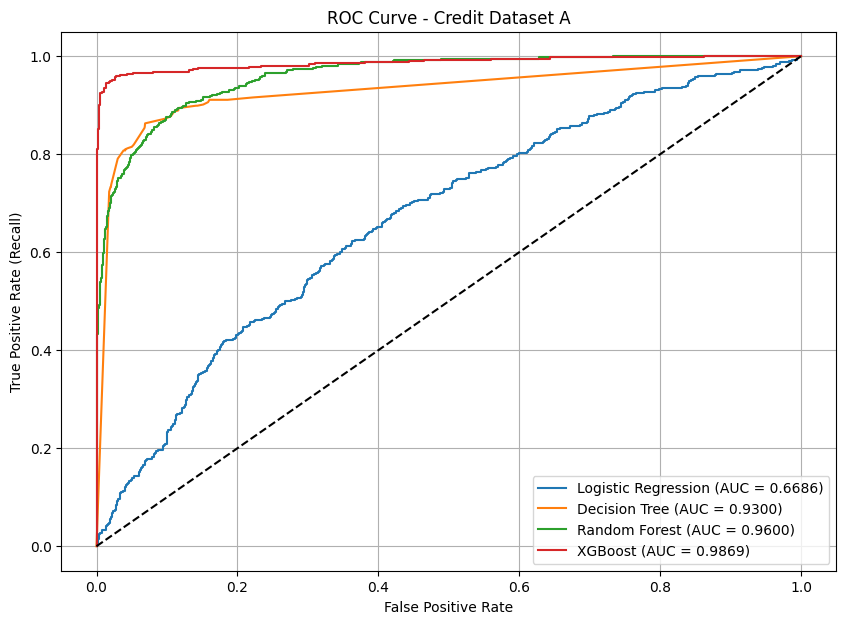

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curves and AUCs
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

auc_lr = roc_auc_score(y_test, y_proba_lr)
auc_dt = roc_auc_score(y_test, y_proba_dt)
auc_rf = roc_auc_score(y_test, y_proba_rf)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# Plot
plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Credit Dataset A')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
